<font size="5">Fashion-MNIST Multilayer Perceptron (TensorFlow)</font>

<u>Upcoming<u/>
- Improve Performance
  - Convert ndarrays to tensors for automatic differentiation support
  - Display performance metrics in confusion matrix; reduce error rate
  - Tune hyperparameters (learning rate/schedule, # layers, neurons per layer, neuron dropout, etc.)
- Reduce Computational Cost
  - Utilize 32-bit tensors for improved speed, minimized RAM usage

<br />

<u>Quick Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [2]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from pathlib import Path
from time import strftime
import datetime
import random

%load_ext tensorboard

In [3]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
pd.DataFrame(fmnist_full).head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
#Sample 1a: Visualize record stored in DataFrame
 #Select random df record
sample1a = fmnist_full.sample(1)
 #Output sample 1 category from df
s1a_class = sample1a['label'].values[0]
print('Item clothing category:', class_names[s1a_class])
 #Preview sample index+values
print(sample1a[['label','pixel18','pixel392','pixel750']])

Item clothing category: Shirt
       label  pixel18  pixel392  pixel750
53387      6       64         0        61


In [6]:
 #Store sample features
sample1a = sample1a.drop(sample1a[['label']], axis=1)
s1a_vals = sample1a.values[0]
 #Reshape sample features for visualization
s1a_img = s1a_vals.reshape(28, 28)

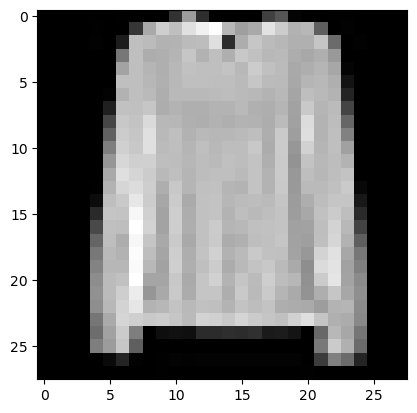

In [7]:
#Display sample in original cmap (grayscale)
plt.imshow(s1a_img, cmap='gray');

In [8]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [9]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [10]:
#Convert feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

In [11]:
#Convert target df to array
y = y.to_numpy()
y.shape

(70000,)

In [12]:
#Sample 1b: Re-locate in array; visualize to verify 
 #Store index value
s1_index = sample1a.index
 #Preview value
s1_index

Index([53387], dtype='int64')

In [13]:
 #Output sample category from target array
s1b_class = y[s1_index][0]

print('Item clothing category:', class_names[s1b_class])

Item clothing category: Shirt


In [14]:
 #Store sample values from reshaped array
sample1b = X_28[s1_index][0]
 #Display integer values
print(sample1b.dtype)
sample1b[0][0:40]

int64


array([  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,  50, 156,  46,
         0,   0,   0,   0,  64,  85,   4,   0,   0,   1,   1,   0,   0,
         0,   0], dtype=int64)

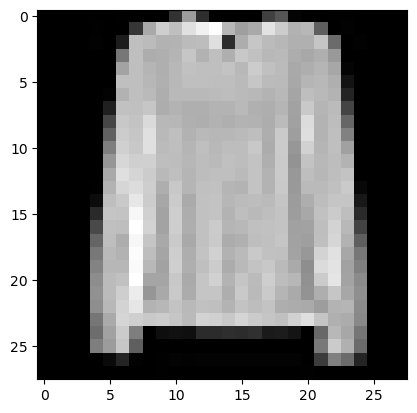

In [15]:
#Display sample 1b in original cmap (grayscale)
plt.imshow(sample1b, cmap='gray');

In [16]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [17]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 records to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [18]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 510
1 481
2 500
3 496
4 530
5 508
6 506
7 468
8 516
9 485


In [19]:
#Split training data into 55,000 train + 5,000 validation
 #Use sklearn 'train_test_split' to stratify by label, preserving label balance more precisely than index slice/keras api
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [20]:
#Verify shapes
print(X_train.shape, y_tr.shape)
print(X_valid.shape, y_val.shape)
print(X_te.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [21]:
#Verify balance
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [22]:
 #Map and display dictionary for training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [23]:
 #Map and display dictionary for validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [24]:
 #Map and display dictionary for test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [25]:
#Scale feature sets from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

In [26]:
#Sample 2: Visualize post-splits, post-scaling sample
sample2 = X_tr_sc[0]
#Verify transformation to float values
print(sample2.dtype)
sample2[0][0:40]

float64


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01176471, 0.        ,
       0.        , 0.81568627, 0.83921569, 0.8       , 0.71764706,
       0.9372549 , 0.27843137, 0.        , 0.        , 0.00784314,
       0.00784314, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [27]:
s2_class = y_tr[0]
print(class_names[s2_class])

T-shirt/top


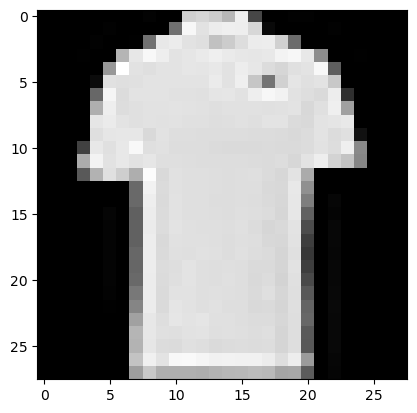

In [28]:
plt.imshow(sample2, cmap='gray');

In [29]:
#TensorBoard log directory setup
log_dir = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Define callbacks
 #Event log callback
event_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
 #Model checkpoint callback
checkp_cb = tf.keras.callbacks.ModelCheckpoint("DNN1 Checkpoints", save_best_only=True)
 #Early stopping callback
stop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)
 #Bundle
cb_list = [event_cb, checkp_cb, stop_cb]

In [31]:
#Build Network 1
 #2 Hidden layers (300 * 100 nodes)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(300, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
#Preview initialized weights and biases
layer_100node = dnn1.layers[2]
layer_100node.name

'dense_4'

In [33]:
weights_100, biases_100 = layer_100node.get_weights()
print(weights_100.shape)
weights_100

(300, 100)


array([[-0.01461487, -0.11351595,  0.1002331 , ..., -0.11127213,
         0.07698844, -0.02632266],
       [-0.0306355 ,  0.00644807, -0.07596336, ..., -0.03208958,
         0.08240686,  0.08660079],
       [-0.0032037 ,  0.09257168,  0.11670937, ...,  0.09498142,
         0.08463483,  0.1149474 ],
       ...,
       [ 0.03239945, -0.01515303,  0.10282291, ...,  0.06260934,
        -0.06061026,  0.02916285],
       [-0.10457118,  0.09848539, -0.02736607, ..., -0.09315305,
         0.06501275, -0.09923513],
       [-0.06408621, -0.05478234, -0.10093452, ...,  0.04832544,
         0.05757899, -0.01640654]], dtype=float32)

In [34]:
print(biases_100.shape)
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [35]:
optimizer1 = tf.keras.optimizers.SGD() #default: 0.01

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

In [37]:
#Train network + store results
epoch_count = 50
history1 = dnn1.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list, verbose=2)

Epoch 1/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.4302 - accuracy: 0.8497 - val_loss: 0.4335 - val_accuracy: 0.8496 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.4071 - accuracy: 0.8577 - val_loss: 0.4194 - val_accuracy: 0.8552 - 3s/epoch - 2ms/step
Epoch 3/50
1719/1719 - 3s - loss: 0.3885 - accuracy: 0.8641 - val_loss: 0.4322 - val_accuracy: 0.8470 - 3s/epoch - 2ms/step
Epoch 4/50
1719/1719 - 3s - loss: 0.3737 - accuracy: 0.8684 - val_loss: 0.4432 - val_accuracy: 0.8388 - 3s/epoch - 2ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3608 - accuracy: 0.8728 - val_loss: 0.3873 - val_accuracy: 0.8612 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3500 - accuracy: 0.8763 - val_loss: 0.3703 - val_accuracy: 0.8678 - 3s/epoch - 2ms/step
Epoch 7/50
1719/1719 - 3s - loss: 0.3403 - accuracy: 0.8788 - val_loss: 0.3723 - val_accuracy: 0.8650 - 3s/epoch - 2ms/step
Epoch 8/50
1719/1719 - 3s - loss: 0.3321 - accuracy: 0.8812 - val_loss: 0.3795 - val_accuracy: 0.8662 - 3s/epoch - 2ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3222 - accuracy: 0.8852 - val_loss: 0.3592 - val_accuracy: 0.8674 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3159 - accuracy: 0.8874 - val_loss: 0.3553 - val_accuracy: 0.8696 - 3s/epoch - 2ms/step
Epoch 11/50
1719/1719 - 3s - loss: 0.3087 - accuracy: 0.8902 - val_loss: 0.3622 - val_accuracy: 0.8686 - 3s/epoch - 2ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.3018 - accuracy: 0.8918 - val_loss: 0.3527 - val_accuracy: 0.8686 - 3s/epoch - 2ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2949 - accuracy: 0.8945 - val_loss: 0.3415 - val_accuracy: 0.8776 - 3s/epoch - 2ms/step
Epoch 14/50
1719/1719 - 3s - loss: 0.2895 - accuracy: 0.8950 - val_loss: 0.3429 - val_accuracy: 0.8736 - 3s/epoch - 2ms/step
Epoch 15/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2843 - accuracy: 0.8983 - val_loss: 0.3347 - val_accuracy: 0.8778 - 3s/epoch - 2ms/step
Epoch 16/50
1719/1719 - 3s - loss: 0.2777 - accuracy: 0.8996 - val_loss: 0.3444 - val_accuracy: 0.8746 - 3s/epoch - 2ms/step
Epoch 17/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2741 - accuracy: 0.9009 - val_loss: 0.3307 - val_accuracy: 0.8776 - 3s/epoch - 2ms/step
Epoch 18/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2683 - accuracy: 0.9036 - val_loss: 0.3271 - val_accuracy: 0.8798 - 3s/epoch - 2ms/step
Epoch 19/50
1719/1719 - 3s - loss: 0.2637 - accuracy: 0.9059 - val_loss: 0.3325 - val_accuracy: 0.8796 - 3s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 3s - loss: 0.2587 - accuracy: 0.9073 - val_loss: 0.3332 - val_accuracy: 0.8764 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 3s - loss: 0.2543 - accuracy: 0.9093 - val_loss: 0.3352 - val_accuracy: 0.8750 - 3s/epoch - 2ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2505 - accuracy: 0.9104 - val_loss: 0.3235 - val_accuracy: 0.8826 - 3s/epoch - 2ms/step
Epoch 23/50
INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


INFO:tensorflow:Assets written to: DNN1 Checkpoints\assets


1719/1719 - 3s - loss: 0.2462 - accuracy: 0.9118 - val_loss: 0.3218 - val_accuracy: 0.8802 - 3s/epoch - 2ms/step
Epoch 24/50
1719/1719 - 3s - loss: 0.2431 - accuracy: 0.9122 - val_loss: 0.3238 - val_accuracy: 0.8806 - 3s/epoch - 2ms/step
Epoch 25/50
1719/1719 - 3s - loss: 0.2377 - accuracy: 0.9143 - val_loss: 0.3244 - val_accuracy: 0.8842 - 3s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 3s - loss: 0.2344 - accuracy: 0.9164 - val_loss: 0.3320 - val_accuracy: 0.8780 - 3s/epoch - 2ms/step
Epoch 27/50
1719/1719 - 3s - loss: 0.2298 - accuracy: 0.9181 - val_loss: 0.3228 - val_accuracy: 0.8826 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 3s - loss: 0.2267 - accuracy: 0.9198 - val_loss: 0.3277 - val_accuracy: 0.8796 - 3s/epoch - 2ms/step


In [38]:
#Save best model
dnn1.save("best_dnn1", save_format="tf")

INFO:tensorflow:Assets written to: best_dnn1\assets


INFO:tensorflow:Assets written to: best_dnn1\assets


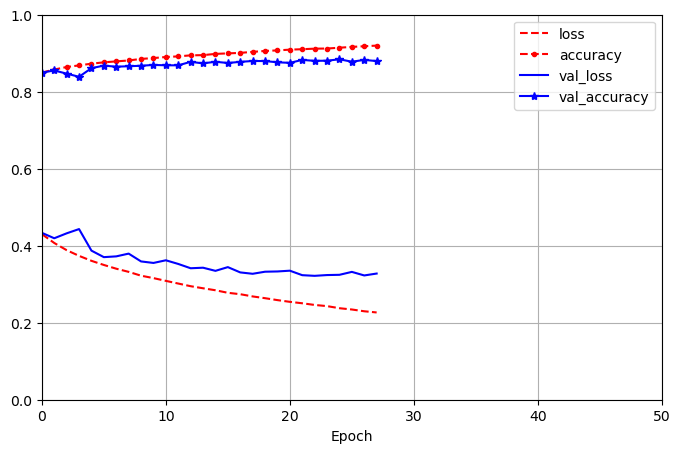

In [39]:
#Visualize learning curves manually
dnn1_learn_curves = pd.DataFrame(history1.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'])
plt.show()

In [41]:
#Load best model for evaluation
best_dnn1 = tf.keras.models.load_model("best_dnn1")

In [42]:
#Evaluate best model on test set
best_dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 1s 1ms/step - loss: 0.3105 - accuracy: 0.8911


[0.3104778826236725, 0.8910999894142151]

In [43]:
#Verify result with original / non-loaded model
dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.3105 - accuracy: 0.8911


[0.3104778826236725, 0.8910999894142151]

In [47]:
#Display learning curves in TensorBoard
%tensorboard --logdir tensorboard_logs/fit

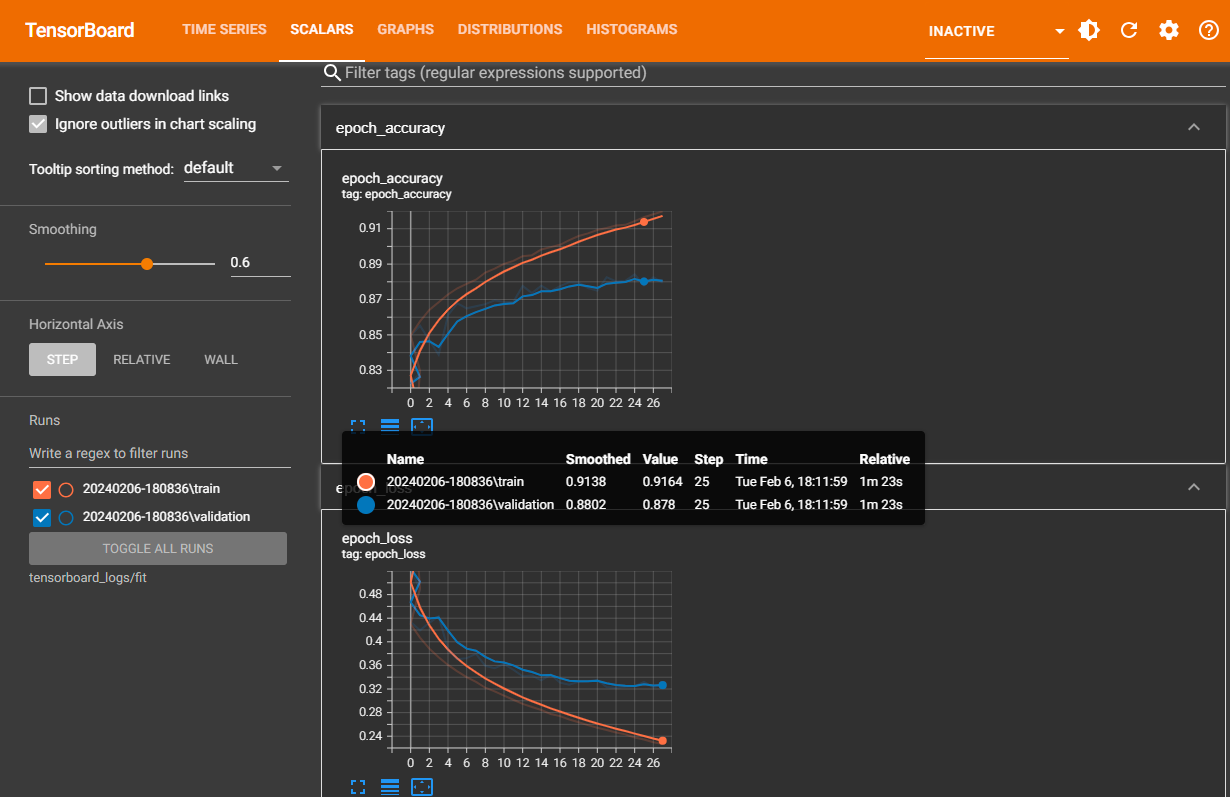

In [48]:
#Store predictions from model
preds1 = best_dnn1.predict(X_te_sc)

313/313 [==============================] - 0s 1ms/step


In [49]:
#Review shapes for test label+prediction arrays
 #Prediction array includes one probability per class, for each instance
print(y_te.shape, preds1.shape)
print('Example classwise probabilities:')
pd.DataFrame({'Probabilities': preds1[0]})

(10000,) (10000, 10)
Example classwise probabilities:


,Probabilities
0,2.523781e-05
1,1.039872e-05
2,9.658723e-01
3,1.500043e-05
4,2.046275e-02
5,1.693065e-08
6,1.353010e-02
7,1.980051e-07
8,8.376332e-05
9,1.421628e-07


Instance #: 8653/10,000
True class of instance: 0 (T-shirt/top)
Predicted class of instance: 0 (T-shirt/top)
Model's confidence in prediction: 0.9134866
AxesImage(shape=(28, 28))


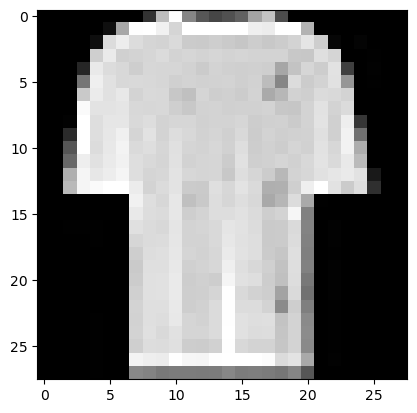

In [50]:
#Sample 3: Compare actual and predicted class for random prediction set instance
 #Select index value for sample
instance_val = random.randint(0,10000)

 #Store values
sample4 = X_te_sc[instance_val]
s4_class_true = y_te[instance_val]
s4_class_pred = np.argmax(preds1[instance_val])
s4_conf = max(preds1[instance_val])

 #Output instance #, true class, predicted class, and prediction confidence for sample
print('Instance #: '+str(instance_val+1)+'/10,000')
print('True class of instance: '+str(s4_class_true)+' ('+class_names[s4_class_true]+')')
print('Predicted class of instance: '+str(s4_class_pred)+' ('+class_names[s4_class_pred]+')')
print('Model\'s confidence in prediction: '+str(s4_conf))

#Display sample 4 image
print(plt.imshow(sample4, cmap='gray'));

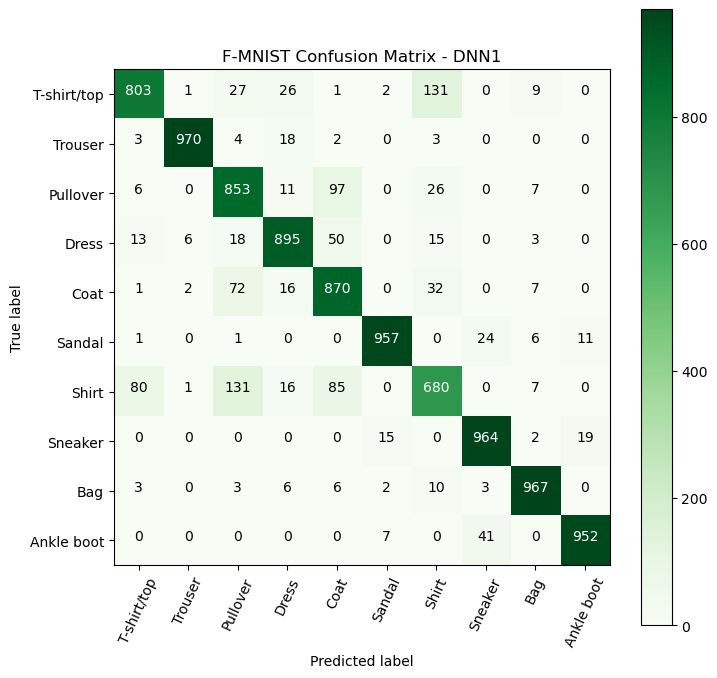

In [51]:
#Confusion Matrix 1: Predictions (non-normalized)
 #manual method
confusion_matrix1 = confusion_matrix(y_te, np.argmax(preds1, axis=1))

plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix1, cmap='Greens')
plt.title('F-MNIST Confusion Matrix - DNN1')
plt.colorbar()
plt.xticks(np.arange(10), class_names, rotation=65)
plt.yticks(np.arange(10), class_names)

for i, j in product(range(confusion_matrix1.shape[0]), range(confusion_matrix1.shape[1])):
    plt.text(j, i, confusion_matrix1[i, j],
    horizontalalignment="center",
    color="white" if confusion_matrix1[i, j] > 500 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label');

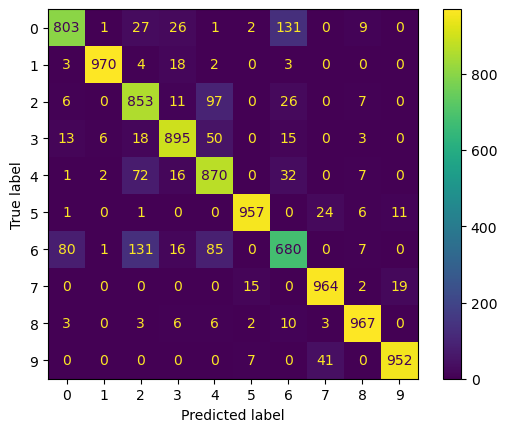

In [52]:
#Confusion matrix 2: Predictions (non-normalized)
 #ConfusionMatrixDisplay method
confusion_matrix2 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1))
plt.show()

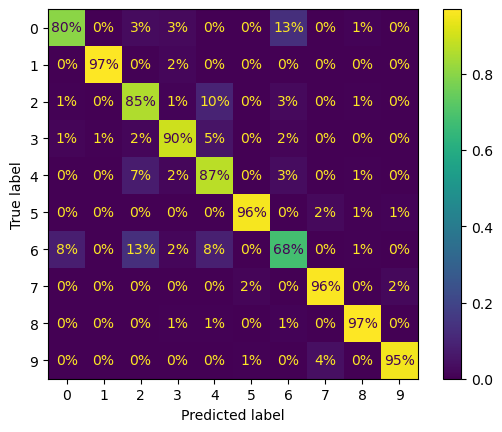

In [53]:
#Confusion matrix 3: Predictions (normalized by row)
confusion_matrix3 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='true')
plt.show()

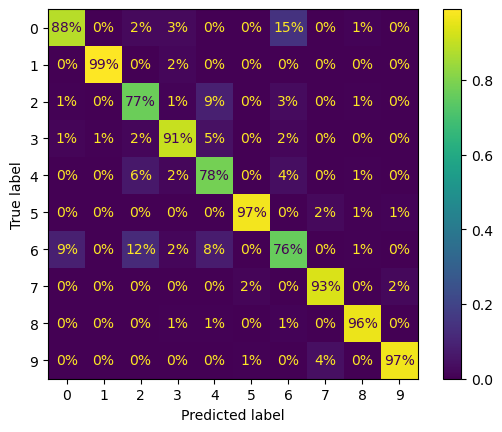

In [54]:
#Confusion matrix 4: Predictions (normalized by column)
confusion_matrix4 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='pred')
plt.show()

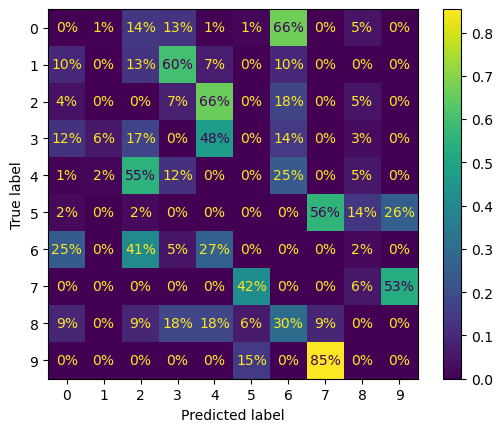

In [55]:
#Confusion matrix 5: Errors (normalized by row)
sample_weights = (np.argmax(preds1, axis=1) != y_te)

confusion_matrix5 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='true', sample_weight=sample_weights)
plt.show()

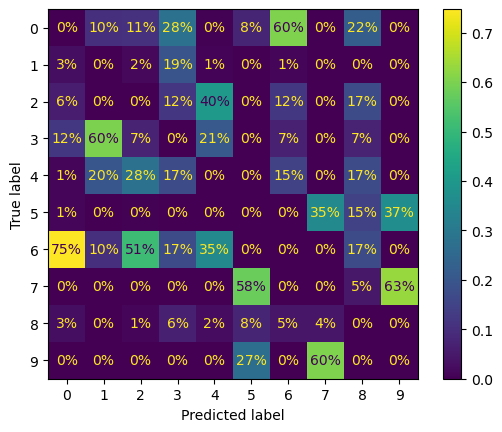

In [56]:
#Confusion matrix 6: Errors (normalized by column)
confusion_matrix5 = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), values_format='.0%', normalize='pred', sample_weight=sample_weights)
plt.show()